In [1]:
import numpy as np
import sys,shutil
from pathlib import Path

import scipy.optimize as syopt
import scipy.special as sysp

sys.path.append('../../code/')
from polynomials import Polynomials
from paths import ML_Path
sys.path.append(ML_Path)
from utilities import Utilities

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc
from time import time

# These imports needed for MCMC using Cobaya
from cobaya.yaml import yaml_load_file
from cobaya.run import run

from getdist.mcsamples import MCSamplesFromCobaya,MCSamples
from getdist.mcsamples import loadMCSamples
import getdist.plots as gdplt

ut = Utilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18 # 14
mpl.rcParams['legend.labelspacing'] = 0.25

FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

***
# MCMC Tutorial
### Polynomial and Gaussian-mixture fits assuming Gaussian likelihood
***

## Setup

In [3]:
Base_Dir = './'
Code_Dir = '../../code/'
# Data_Dir = Base_Dir + 'data/'
Plots_Dir = Base_Dir + 'plots/'
Stats_Dir = Base_Dir + 'stats/'
Like_Dir = Code_Dir + 'likes/'

In [4]:
Like_Dir

'../../code/likes/'

## Polynomial

In [5]:
poly = Polynomials()

In [6]:
params_true = np.array([1.0,0.0,-1.0,2.0]) 
dim = len(params_true) # parameter dimensionality
Degree = dim-1

model_suffix = 'polydeg{0:d}'.format(dim-1)

xvals = np.linspace(-0.5,2.0,40)
cov_mat = np.linspace(0.15**2,0.85**2,xvals.size)*np.eye(xvals.size)
err_data = np.sqrt(np.diag(cov_mat))

SEED = 1991
rng = np.random.RandomState(seed=SEED)

true_model = poly.model_poly(xvals,params_true)
data = true_model + rng.multivariate_normal(np.zeros(cov_mat.shape[0]),cov_mat)

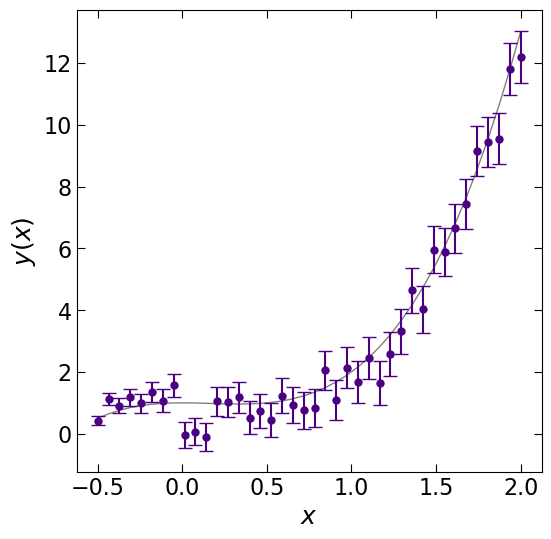

In [7]:
plt.figure(figsize=(6,6))
plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.plot(xvals,true_model,ls='-',c='gray',lw=1)
plt.errorbar(xvals,data,yerr=err_data,marker='o',c='indigo',capsize=5,ls='none',markersize=5)
plt.show()

### Analytical answer

In [8]:
apoly,cov_poly = poly.polyfit_custom(xvals,data,dim-1,sig2=err_data**2)
sig_apoly = np.sqrt(np.diagonal(cov_poly))

print('Best poly fit...')
print("... values ( a0,..,a{0:d} ) = ( ".format(dim-1)
      +','.join(['%.3f' % (ai,) for ai in apoly])+" )")
print("... errors ( sig_a0,..,sig_a{0:d} ) = ( ".format(dim-1)
      +','.join(['%.3f' % (sigi,) for sigi in sig_apoly])+" )")
print("... full cov = \n",cov_poly)

chi2_analytical = np.sum(((data - poly.model_poly(xvals,apoly))/err_data)**2)
dof = xvals.size - dim
pval_analytical = sysp.gammaincc(0.5*dof,0.5*chi2_analytical)

print('... chi2 = {0:.2f}; dof = {1:d}; p-value = {2:.3e}'.format(chi2_analytical,dof,pval_analytical))

print('... done')

Best poly fit...
... values ( a0,..,a3 ) = ( 0.906,-0.402,-0.728,1.951 )
... errors ( sig_a0,..,sig_a3 ) = ( 0.120,0.184,0.455,0.243 )
... full cov = 
 [[ 0.01431365  0.0075327  -0.04289934  0.01917918]
 [ 0.0075327   0.03376077 -0.01990453 -0.00227252]
 [-0.04289934 -0.01990453  0.20691671 -0.10391453]
 [ 0.01917918 -0.00227252 -0.10391453  0.0591801 ]]
... chi2 = 37.12; dof = 36; p-value = 4.173e-01
... done


Poly deg: 0
... values ( a0,..,a0 ) = ( 1.457 )
... errors ( sig_a0,..,sig_a0 ) = ( 0.068 )
... chi2 = 915.01; dof = 36; p-value = 9.995e-169
... AICc = 917.30


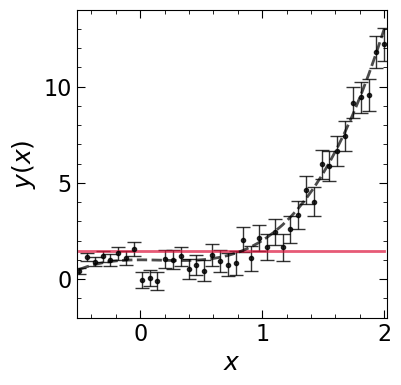

----
Poly deg: 1
... values ( a0,..,a1 ) = ( 1.291,2.308 )
... errors ( sig_a0,..,sig_a1 ) = ( 0.068,0.102 )
... chi2 = 398.94; dof = 36; p-value = 9.040e-63
... AICc = 403.51


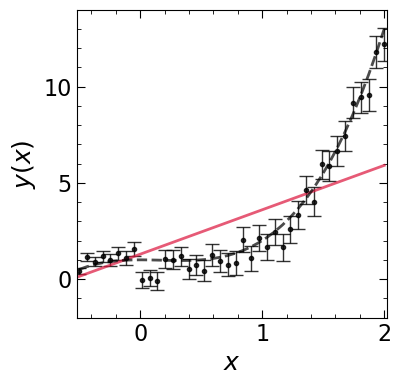

----
Poly deg: 2
... values ( a0,..,a2 ) = ( 0.274,-0.327,2.697 )
... errors ( sig_a0,..,sig_a2 ) = ( 0.090,0.184,0.156 )
... chi2 = 101.43; dof = 36; p-value = 3.819e-08
... AICc = 108.29


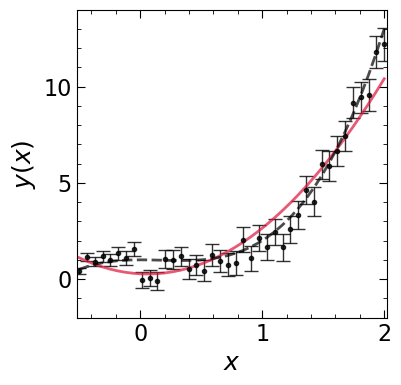

----
Poly deg: 3
... values ( a0,..,a3 ) = ( 0.906,-0.402,-0.728,1.951 )
... errors ( sig_a0,..,sig_a3 ) = ( 0.120,0.184,0.455,0.243 )
... chi2 = 37.12; dof = 36; p-value = 4.173e-01
... AICc = 46.26


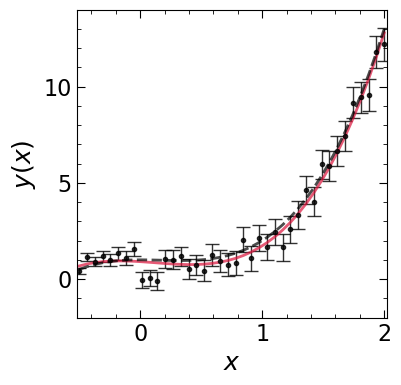

----
Poly deg: 4
... values ( a0,..,a4 ) = ( 0.961,-0.855,-1.261,3.459,-0.598 )
... errors ( sig_a0,..,sig_a4 ) = ( 0.125,0.342,0.567,0.990,0.381 )
... chi2 = 34.65; dof = 36; p-value = 5.328e-01
... AICc = 46.08


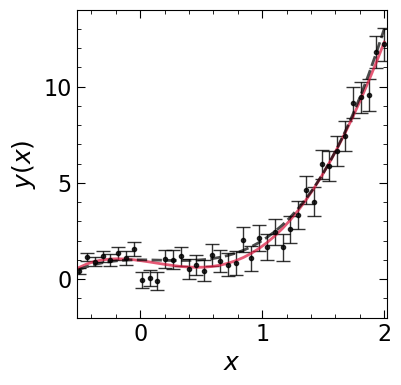

----
Poly deg: 5
... values ( a0,..,a5 ) = ( 0.917,-1.321,-0.692,5.173,-2.942,0.714 )
... errors ( sig_a0,..,sig_a5 ) = ( 0.130,0.519,0.741,1.746,2.002,0.599 )
... chi2 = 33.23; dof = 36; p-value = 6.011e-01
... AICc = 46.94


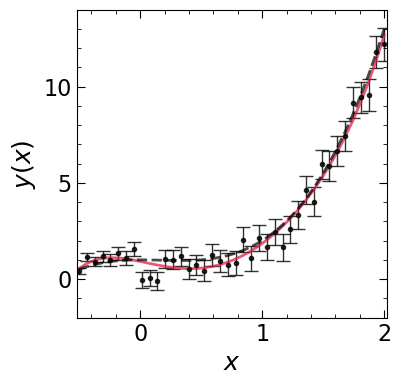

----
... done


In [9]:
DegMax = 5
aicc = {deg:0.0 for deg in range(DegMax+1)}
for deg in range(DegMax+1):
    apoly,cov_poly = poly.polyfit_custom(xvals,data,deg,sig2=err_data**2)
    if deg == 0:
        apoly = np.array([apoly])
    sig_apoly = np.sqrt(np.diagonal(cov_poly))

    print('Poly deg: {0:d}'.format(deg))
    print("... values ( a0,..,a{0:d} ) = ( ".format(deg)
          +','.join(['%.3f' % (ai,) for ai in apoly])+" )")
    print("... errors ( sig_a0,..,sig_a{0:d} ) = ( ".format(deg)
          +','.join(['%.3f' % (sigi,) for sigi in sig_apoly])+" )")

    chi2_analytical_deg = np.sum(((data - poly.model_poly(xvals,apoly))/err_data)**2)
    dof_deg = xvals.size - (deg+1)
    pval_analytical_deg = sysp.gammaincc(0.5*dof,0.5*chi2_analytical_deg)
    aicc_analytical_deg = chi2_analytical_deg + 2*xvals.size*(deg+1)/(dof-1)
    aicc[deg] = aicc_analytical_deg

    print('... chi2 = {0:.2f}; dof = {1:d}; p-value = {2:.3e}'.format(chi2_analytical_deg,dof,pval_analytical_deg))
    print('... AICc = {0:.2f}'.format(aicc_analytical_deg))
    
    X_Min,X_Max = xvals[0]-0.02,xvals[-1]+0.02
    Y_Min,Y_Max = -2.0,14.0

    plt.figure(figsize=(4,4))
    plt.xlim(X_Min,X_Max)
    plt.ylim(Y_Min,Y_Max)
    plt.xlabel('$x$')
    plt.ylabel('$y(x)$')

    plt.errorbar(xvals,data,yerr=err_data,marker='o',ls='none',c='k',capsize=5,markersize=3,lw=1,alpha=0.8)
    plt.plot(xvals,poly.model_poly(xvals,apoly),ls='-',c='crimson',alpha=0.7,lw=2,label='analytical')
    plt.plot(xvals,true_model,ls='--',c='k',alpha=0.7,lw=2,label='true')

    # plt.legend(loc='upper left')
    plt.minorticks_on()
    plt.show()

    print('----')

print('... done')

In [10]:
deg_best = 3 # list(aicc.keys())[np.argmin(list(aicc.values()))]
apoly,cov_poly = poly.polyfit_custom(xvals,data,deg_best,sig2=err_data**2)
if deg == 0:
    apoly = np.array([apoly])
sig_apoly = np.sqrt(np.diagonal(cov_poly))

### MCMC

In [11]:
Run_Cobaya = True
Show_Cobaya = True
Resume = False

Max_Samples = 1000000
Rminus1_Stop = 0.01 
Rminus1_CL_Stop = 0.05
Rminus1_CL_Level = 0.99
Burn_In = 0

Latex_List = []
Params_List = []
for m in range(Degree+1):
    Latex_List.append('a_{'+str(m)+'}') 
    Params_List.append('a'+str(m))

info = {}
info['likelihood'] = {'likelihoods.Chi2Like':
                      {'python_path':Like_Dir,
                       'data':data,
                       'cov_mat':cov_mat}}

info['theory'] = {'likelihoods.PolyTheory':
                  {'python_path':Like_Dir,
                   'xvals':xvals}}

info['params'] = {}
for m in range(Degree+1):
    info['params'][Params_List[m]] = {'ref': {'min': -0.001, 'max': 0.001},
                                      'prior': {'min': -10.0, 'max': 10.0},
                                      'proposal': 0.01,'latex': Latex_List[m]}


info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 1000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}

info['output'] = 'stats/chains/poly_deg{0:d}'.format(Degree)
if Resume:
    info["resume"] = True
else:
    info["force"] = True
print('... done with setup')

... done with setup


In [12]:
if Run_Cobaya:
    start_time = time()
    updated_info, sampler = run(info)
    ut.time_this(start_time)

[output] Output to be read-from/written-into folder 'stats/chains', with prefix 'poly_deg3'
[output] Found existing info files with the requested output prefix: 'stats/chains/poly_deg3'
[output] Will delete previous products ('force' was requested).


[vivaldi-piccolo:102728] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: a0:0.0009026192, a1:0.0006748791, a2:0.000855784, a3:-5.125352e-05
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihoods.Chi2Like: 18100.0, likelihoods.PolyTheory: 52100.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-02-21 14:10:02 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.582
[mcmc]  - Convergence of means: R-1 = 28.239247 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 320 samples accepted.
[mcmc]  - Acceptance rate: 0.470
[mcmc]  - Convergence of means: R-1 = 9.857717 after 256 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + conver

### Plot

In [13]:
Save_Fig = True

In [14]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
dof = xvals.size - dim

MCMC...
... best fit ( a0,..,a3 ) = ( 0.9184,-0.3746,-0.7908,1.9762 )
... std dev  ( a0,..,a3 ) = ( 0.1207,0.1866,0.4583,0.2460 )
... chi2_best,dof: 37.154,36
Best poly fit...
... values ( a0,..,a3 ) = ( 0.906,-0.402,-0.728,1.951 )
... errors ( sig_a0,..,sig_a3 ) = ( 0.120,0.184,0.455,0.243 )
... chi2 = 37.12; dof = 36; p-value = 4.173e-01
Writing to file: ./plots/contours_poly_deg3.png
N_Boot_Cobaya:  1000
[....................] 100% done
Writing to file: ./plots/model_poly_deg3.png
0 min 1.69 seconds



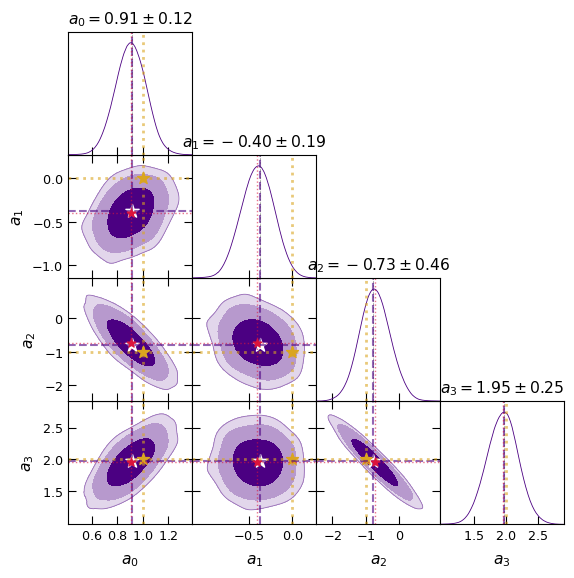

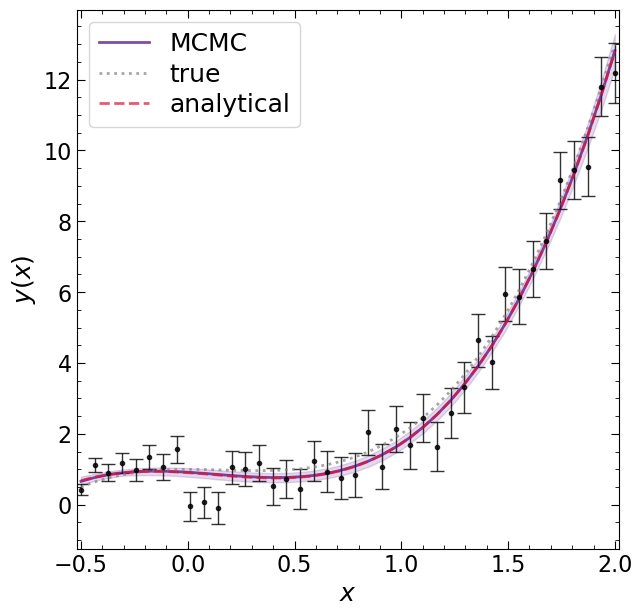

In [15]:
if Show_Cobaya:
    start_time = time()
    gd_sample = loadMCSamples(info["output"],settings={'ignore_rows':Burn_Frac})
    # gd_sample = loadMCSamples(os.path.abspath(info["output"]),settings={'ignore_rows':Burn_Frac})
    # samples contain a0..a(dim-2),b,beta,sigv,[Qb22,Qb42,Qb44] | chi2 | chi2__name | ?? | ??
    mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]

    sample = np.loadtxt(info["output"]+'.1.txt')
    # sample = np.loadtxt(os.path.abspath(info["output"])+'.1.txt')
    sample = sample[int(Burn_Frac*sample.shape[0]):]
    sample = sample.T
    # expect wt | -ln(post) | params | stuff..
    ibest = sample[1].argmin()
    mcmc_best = sample[2:dim+2,ibest]
    mcmc_chi2 = sample[dim+4,ibest]
    mcmc_sig = np.sqrt(np.diag(mcmc_covmat))

    print('MCMC...')
    print("... best fit ( a0,..,a{0:d} ) = ( ".format(Degree)
          +','.join(['%.4f' % (pval,) for pval in mcmc_best])+" )")
    print("... std dev  ( a0,..,a{0:d} ) = ( ".format(Degree)
          +','.join(['%.4f' % (pval,) for pval in mcmc_sig])+" )")
    print("... chi2_best,dof: {0:.3f},{1:d}".format(mcmc_chi2,dof))
    
    print('Best poly fit...')
    print("... values ( a0,..,a{0:d} ) = ( ".format(dim-1)
          +','.join(['%.3f' % (ai,) for ai in apoly])+" )")
    print("... errors ( sig_a0,..,sig_a{0:d} ) = ( ".format(dim-1)
          +','.join(['%.3f' % (sigi,) for sigi in sig_apoly])+" )")
    print('... chi2 = {0:.2f}; dof = {1:d}; p-value = {2:.3e}'.format(chi2_analytical,dof,pval_analytical))
        
    plot_param_list = Params_List
    param_dim = dim
    par_offset = 0
    Subplot_Size = 1.6

    gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
    gdplot.settings.num_plot_contours = 3
    gdplot.settings.axes_fontsize = FS3
    gdplot.settings.axes_labelsize = FS2
    gdplot.settings.title_limit_fontsize = FS2

    gdplot.triangle_plot([gd_sample], plot_param_list,
                         filled=[True],contour_colors=['indigo'],legend_loc='upper center',
                         markers=mcmc_best[par_offset:],
                         marker_args={'c': 'indigo','ls': '--','lw': 1.5,'alpha': 0.6},
                         title_limit=1)
    for par_y in range(param_dim):
        str_y = plot_param_list[par_y]
        ax = gdplot.subplots[par_y,par_y]
        ax.axvline(mcmc_best[par_y+par_offset],c='indigo',ls='--',lw=1.5,alpha=0.6)
        if par_y+par_offset < len(plot_param_list):
            ax.axvline(params_true[par_y+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
            ax.axvline(apoly[par_y+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)
        for par_x in range(par_y):
            str_x = plot_param_list[par_x]
            ax = gdplot.subplots[par_y,par_x]
            ax.scatter([mcmc_best[par_x+par_offset]],[mcmc_best[par_y+par_offset]],
                       marker='*',s=100,c='white')
            if (par_x+par_offset < len(plot_param_list)) & (par_y+par_offset < len(plot_param_list)):
                ax.scatter([params_true[par_x+par_offset]],[params_true[par_y+par_offset]],
                           marker='*',s=80,c='goldenrod')
                ax.axvline(params_true[par_x+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
                ax.axhline(params_true[par_y+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
                ax.scatter([apoly[par_x+par_offset]],[apoly[par_y+par_offset]],
                           marker='*',s=40,c='crimson',zorder=10)
                ax.axvline(apoly[par_x+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)
                ax.axhline(apoly[par_y+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)

    if Save_Fig:
        filename = 'contours_poly_deg{0:d}.png'.format(deg_best)
        print('Writing to file: '+Plots_Dir+filename)
        gdplot.export(fname=filename,adir=Plots_Dir)

    poly_best = poly.model_poly(xvals,mcmc_best)
    Nsample = gd_sample.samples.shape[0]

    N_Boot_Cobaya = np.min([1000,int(0.2*sample[0].size)])
    print('N_Boot_Cobaya: ',N_Boot_Cobaya)
    
    poly_boot = np.zeros((N_Boot_Cobaya,xvals.size),dtype=float)
    Ind = rng.choice(Nsample,size=np.min([N_Boot_Cobaya,Nsample]),replace=False)

    for b in range(N_Boot_Cobaya):
        params_b = sample[2:2+dim,Ind[b]]
    
        poly_boot[b] = poly.model_poly(xvals,params_b)
        ut.status_bar(b,N_Boot_Cobaya)


    poly_16pc = np.percentile(poly_boot,16,axis=0)
    poly_84pc = np.percentile(poly_boot,84,axis=0)

    del poly_boot,Ind
    gc.collect()

    X_Min,X_Max = xvals[0]-0.02,xvals[-1]+0.02
    Y_Min,Y_Max = -1.0,8.0

    plt.figure(figsize=(7,7))
    plt.xlim(X_Min,X_Max)
#     plt.ylim(Y_Min,Y_Max)
    plt.xlabel('$x$')
    plt.ylabel('$y(x)$')

    plt.errorbar(xvals,data,yerr=err_data,marker='o',ls='none',c='k',capsize=5,markersize=3,lw=1,alpha=0.8)
    plt.plot(xvals,poly_best,ls='-',c='indigo',alpha=0.7,lw=2,label='MCMC')
    plt.plot(xvals,true_model,ls=':',c='gray',alpha=0.7,lw=2,label='true')
    plt.plot(xvals,poly.model_poly(xvals,apoly),ls='--',c='crimson',alpha=0.7,lw=2,label='analytical')
    plt.fill_between(xvals,poly_84pc,poly_16pc,color='indigo',alpha=0.15)

    plt.legend(loc='upper left')
    plt.minorticks_on()
    if Save_Fig:
        filename = Plots_Dir+'model_poly_deg{0:d}.png'.format(deg_best)
        print('Writing to file: '+filename)
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show()
    ut.time_this(start_time)

## Gaussian mixture

In [16]:
# params = [amp,mean,sigma,amp,mean,sigma,...]
params_true = np.array([-1.0,0.0,1.0,1.0,5.0,1.5]) 
dim = params_true.size # parameter dimensionality
if (dim % 3) != 0:
    raise TypeError('Incompatible description of true model')
N_Comp = dim // 3

xvals = np.linspace(-6.0,12.0,50)
cov_mat = 0.08**2*np.eye(xvals.size) # 0.02,0.08
err_data = np.sqrt(np.diag(cov_mat))
invcov_data,detC = ut.svd_inv(cov_mat)

SEED = 1991
rng = np.random.RandomState(seed=SEED)

def pGauss(x,*params):
    # expect params = [amp,mu,sigma,amp,mu,sigma,...]
    ncomp = len(params) // 3
    out = np.zeros_like(x)
    for n in range(ncomp):
        comp = -0.5*(x-params[3*n+1])**2/params[3*n+2]**2
        comp = params[3*n]*np.exp(comp)/np.sqrt(2*np.pi)/params[3*n+2]
        out += comp
    return out

true_model = pGauss(xvals,*params_true)
data = true_model + rng.multivariate_normal(np.zeros(cov_mat.shape[0]),cov_mat)
dof = data.size - dim

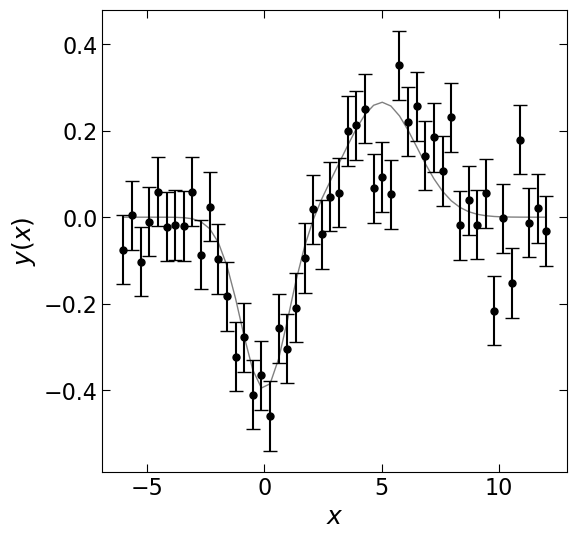

In [17]:
plt.figure(figsize=(6,6))
plt.xlabel('$x$')
plt.ylabel('$y(x)$')
plt.plot(xvals,true_model,ls='-',c='gray',lw=1)
plt.errorbar(xvals,data,yerr=err_data,marker='o',c='k',capsize=5,ls='none',markersize=5)
plt.show()

### Least-squares answer

In [18]:
params_lstsq,pcov_lstsq = syopt.curve_fit(pGauss,xvals,data,p0=[0.0,0.0,3.0,1.0,0.0,3.0],
                                          sigma=cov_mat,absolute_sigma=True,check_finite=False)
perr_lstsq = np.sqrt(np.diag(pcov_lstsq))


def calc_chi2(x,y,inv_cov,params):
    model = pGauss(x,*params)
    residual = y - model
    chi2 = np.dot(residual,np.dot(inv_cov,residual))
    return chi2

chi2_lstsq = calc_chi2(xvals,data,invcov_data,params_lstsq)

print('Least squares...')
print("... best fit ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in params_lstsq])+" )")
print("... std dev  ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in perr_lstsq])+" )")
print("... chi2_best,dof: {0:.3f},{1:d}".format(chi2_lstsq,dof))

Least squares...
... best fit ( a0,..,a6 ) = ( -1.1841,-0.0763,1.1385,0.9714,5.6264,1.8109 )
... std dev  ( a0,..,a6 ) = ( 0.1309,0.1409,0.1446,0.1620,0.3395,0.3651 )
... chi2_best,dof: 48.226,44


### MCMC

In [19]:
Rminus1_Stop = 0.01
Rminus1_CL_Stop = 0.05
Rminus1_CL_Level = 0.95

Burn_In = 0
Max_Samples = 1000000


Latex_List = []
Params_List = []
for n in range(N_Comp):
    Latex_List.append('A_{('+str(n)+')}') 
    Params_List.append('A'+str(n))
    Latex_List.append('\mu_{('+str(n)+')}') 
    Params_List.append('mu'+str(n))
    Latex_List.append('\sigma_{('+str(n)+')}') 
    Params_List.append('sig'+str(n))


info = {}
info['likelihood'] = {'likelihoods.Chi2Like':
                      {'python_path':Like_Dir,
                       'data':data,
                       'cov_mat':cov_mat}}

info['theory'] = {'likelihoods.GaussTheory':
                  {'python_path':Like_Dir,
                   'xvals':xvals}}

info['params'] = {}
# for m in range(dim):
#     info['params'][Params_List[m]] = {'ref': {'min': -0.001, 'max': 0.001},
#                                       'prior': {'min': -10.0, 'max': 10.0},
#                                       'proposal': 0.01,'latex': Latex_List[m]}
for n in range(N_Comp):
    # amplitude
    info['params'][Params_List[3*n]] = {'ref': {'min': -0.001, 'max': 0.001},
                                        'prior': {'min': -10.0, 'max': 10.0},
                                        'proposal': 0.01,'latex': Latex_List[3*n]}

    # mean
    info['params'][Params_List[3*n+1]] = {'ref': {'min': -0.001, 'max': 0.001},
                                          'prior': {'min': -10.0, 'max': 10.0},
                                          'proposal': 0.01,'latex': Latex_List[3*n+1]}

    # sigma (note pos def prior)
    info['params'][Params_List[3*n+2]] = {'ref': {'min': 0.001, 'max': 0.002},
                                          'prior': {'min': 0.0, 'max': 10.0},
                                          'proposal': 0.01,'latex': Latex_List[3*n+2]}


info['sampler'] = {'mcmc':
                   {'learn_proposal': True,
                    'Rminus1_single_split': 4,
                    'measure_speeds': True,
                    'max_samples': Max_Samples,
                    'max_tries': 1000,
                    'Rminus1_stop': Rminus1_Stop,
                    'Rminus1_cl_stop': Rminus1_CL_Stop,
                    'Rminus1_cl_level': Rminus1_CL_Level,
                    'burn_in': Burn_In}}

info['output'] = 'stats/chains/gaussmix_{0:d}'.format(N_Comp)
if Resume:
    info["resume"] = True
else:
    info["force"] = True
print('... done with setup')

... done with setup


In [21]:
start_time = time()
updated_info, sampler = run(info)
ut.time_this(start_time)

[output] Output to be read-from/written-into folder 'stats/chains', with prefix 'gaussmix_2'
[output] Found existing info files with the requested output prefix: 'stats/chains/gaussmix_2'
[output] Will delete previous products ('force' was requested).
[mcmc] Getting initial point... (this may take a few seconds)
[mcmc] Initial point: A0:0.0006204415, mu0:0.0005996331, sig0:0.001177198, A1:0.0002302425, mu1:0.0003730443, sig1:0.001218238
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {likelihoods.Chi2Like: 19200.0, likelihoods.GaussTheory: 40800.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-02-21 14:13:09 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.747
[mcmc]  - Convergence of means: R-1 = 7.604247 after 192 accepted step

In [22]:
Burn_Frac = 0.3
rng = np.random.RandomState(42)
dof = xvals.size - dim

MCMC...
... best fit ( a0,..,a6 ) = ( 0.9621,5.5995,1.7766,-1.1982,-0.0895,1.1628 )
... std dev  ( a0,..,a6 ) = ( 0.4804,1.0413,0.7026,0.4568,0.1962,0.2323 )
... chi2_best,dof: 48.308,44
Least squares...
... best fit ( a0,..,a6 ) = ( -1.1841,-0.0763,1.1385,0.9714,5.6264,1.8109 )
... std dev  ( a0,..,a6 ) = ( 0.1309,0.1409,0.1446,0.1620,0.3395,0.3651 )
... chi2_best,dof: 48.226,44
Writing to file: ./plots/contours_gauss.png
N_Boot_Cobaya:  1000
[....................] 100% done
Writing to file: ./plots/model_gauss.png
0 min 3.38 seconds



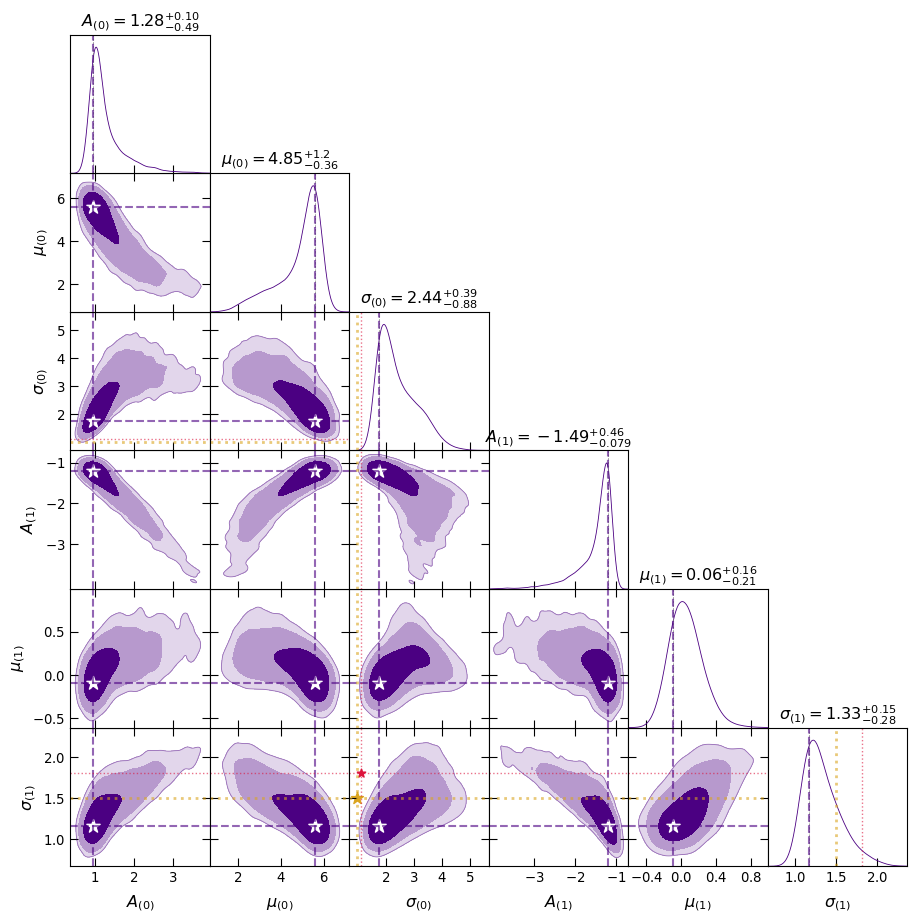

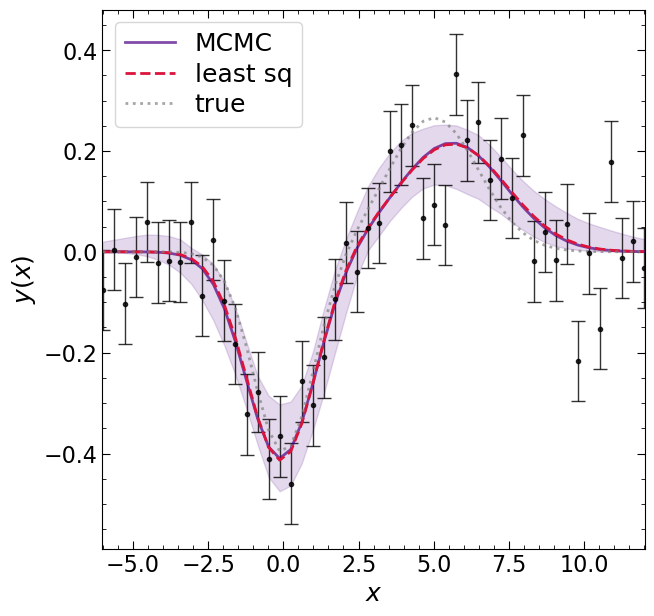

In [23]:
start_time = time()
gd_sample = loadMCSamples(info["output"],settings={'ignore_rows':Burn_Frac})
# samples contain params | chi2 | chi2__name | .. | ..
mcmc_covmat = gd_sample.getCovMat().matrix[:dim, :dim]

sample = np.loadtxt(info["output"]+'.1.txt')
sample = sample[int(Burn_Frac*sample.shape[0]):]
sample = sample.T
# expect wt | -ln(post) | params | stuff..
ibest = sample[1].argmin()
mcmc_best = sample[2:dim+2,ibest]
mcmc_chi2 = sample[dim+4,ibest]
mcmc_sig = np.sqrt(np.diag(mcmc_covmat))

print('MCMC...')
print("... best fit ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in mcmc_best])+" )")
print("... std dev  ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in mcmc_sig])+" )")
print("... chi2_best,dof: {0:.3f},{1:d}".format(mcmc_chi2,dof))

print('Least squares...')
print("... best fit ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in params_lstsq])+" )")
print("... std dev  ( a0,..,a{0:d} ) = ( ".format(dim)
      +','.join(['%.4f' % (pval,) for pval in perr_lstsq])+" )")
print("... chi2_best,dof: {0:.3f},{1:d}".format(chi2_lstsq,dof))

plot_param_list = Params_List
param_dim = dim
par_offset = 0
Subplot_Size = 1.8

gdplot = gdplt.get_subplot_plotter(subplot_size=Subplot_Size)
gdplot.settings.num_plot_contours = 3
gdplot.settings.axes_fontsize = FS3
gdplot.settings.axes_labelsize = FS2
gdplot.settings.title_limit_fontsize = FS2

gdplot.triangle_plot([gd_sample], plot_param_list,
                     filled=[True],contour_colors=['indigo'],legend_loc='upper center',
                     markers=mcmc_best[par_offset:],
                     marker_args={'c': 'indigo','ls': '--','lw': 1.5,'alpha': 0.6},
                     title_limit=1)
for par_y in range(param_dim):
    str_y = plot_param_list[par_y]
    ax = gdplot.subplots[par_y,par_y]
    ax.axvline(mcmc_best[par_y+par_offset],c='indigo',ls='--',lw=1.5,alpha=0.6)
    if par_y+par_offset < len(plot_param_list):
        ax.axvline(params_true[par_y+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
        ax.axvline(params_lstsq[par_y+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)
    for par_x in range(par_y):
        str_x = plot_param_list[par_x]
        ax = gdplot.subplots[par_y,par_x]
        ax.scatter([mcmc_best[par_x+par_offset]],[mcmc_best[par_y+par_offset]],
                   marker='*',s=100,c='white')
        if (par_x+par_offset < len(plot_param_list)) & (par_y+par_offset < len(plot_param_list)):
            ax.scatter([params_true[par_x+par_offset]],[params_true[par_y+par_offset]],
                       marker='*',s=80,c='goldenrod')
            ax.axvline(params_true[par_x+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
            ax.axhline(params_true[par_y+par_offset],c='goldenrod',ls=':',lw=2.0,alpha=0.6)
            ax.scatter([params_lstsq[par_x+par_offset]],[params_lstsq[par_y+par_offset]],
                       marker='*',s=40,c='crimson')
            ax.axvline(params_lstsq[par_x+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)
            ax.axhline(params_lstsq[par_y+par_offset],c='crimson',ls=':',lw=1.0,alpha=0.6)

if Save_Fig:
    filename = 'contours_gauss.png'
    print('Writing to file: '+Plots_Dir+filename)
    gdplot.export(fname=filename,adir=Plots_Dir)


gaussmix_best = pGauss(xvals,*mcmc_best)
Nsample = gd_sample.samples.shape[0]

N_Boot_Cobaya = np.min([1000,int(0.2*sample[0].size)])
print('N_Boot_Cobaya: ',N_Boot_Cobaya)

gaussmix_boot = np.zeros((N_Boot_Cobaya,xvals.size),dtype=float)
Ind = rng.choice(Nsample,size=np.min([N_Boot_Cobaya,Nsample]),replace=False)

for b in range(N_Boot_Cobaya):
    params_b = sample[2:2+dim,Ind[b]]

    gaussmix_boot[b] = pGauss(xvals,*params_b)
    ut.status_bar(b,N_Boot_Cobaya)


gaussmix_16pc = np.percentile(gaussmix_boot,2.5,axis=0)
gaussmix_84pc = np.percentile(gaussmix_boot,97.5,axis=0)

del gaussmix_boot,Ind
gc.collect()

X_Min,X_Max = xvals[0]-0.02,xvals[-1]+0.02
Y_Min,Y_Max = -1.0,8.0

plt.figure(figsize=(7,7))
plt.xlim(X_Min,X_Max)
#     plt.ylim(Y_Min,Y_Max)
plt.xlabel('$x$')
plt.ylabel('$y(x)$')

plt.errorbar(xvals,data,yerr=err_data,marker='o',ls='none',c='k',capsize=5,markersize=3,lw=1,alpha=0.8)
plt.plot(xvals,gaussmix_best,ls='-',c='indigo',alpha=0.7,lw=2,label='MCMC')
plt.plot(xvals,pGauss(xvals,*params_lstsq),ls='--',c='crimson',lw=2,label='least sq')
plt.plot(xvals,true_model,ls=':',c='gray',alpha=0.7,lw=2,label='true')
plt.fill_between(xvals,gaussmix_84pc,gaussmix_16pc,color='indigo',alpha=0.15)

if params_true[0] > 0.0:
    plt.legend(loc='upper right')
else:
    plt.legend(loc='upper left')

plt.minorticks_on()
if Save_Fig:
    filename = Plots_Dir+'model_gauss.png'
    print('Writing to file: '+filename)
    plt.savefig(filename,bbox_inches='tight')
else:
    plt.show()
ut.time_this(start_time)